<a href="https://colab.research.google.com/github/erichsdb/Deep-Reinforcement-Learning/blob/main/notebooks/6-DP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic programming

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The goal of this exercise is to find the optimal policy for the recycling robot.

In this problem, a recycling robot has to search for empty cans to collect (each can defines a "reward" given to the robot). It can also decide to stay where it is to save its battery and wait that somebody brings it a can (which gives less cans in average than actively searching for them).

The robot has two battery levels, *high* and *low*.

* In the *high* level, the robot can either search or wait.

* In the *low* state, three actions are possible: search, wait and recharge.

State-action transitions are probabilistic, i.e. they bring the robot in different states based on different probabilities $\alpha$ and $\beta$.

This problem defines a finite MDP, with two states *high* and *low* corresponding to the battery level. The actions *search* and *wait* are possible in the *high* and *low* states, while the action *recharge* is only possible in the *low* state.

$$
\begin{aligned}
    \mathcal{S} &=& \{ \text{high}, \text{low} \} \\
    \mathcal{A}(\text{high} ) &=& \{ \text{search}, \text{wait} \} \\
    \mathcal{A}(\text{low} ) &=& \{ \text{search}, \text{wait}, \text{recharge} \}
\end{aligned}
$$

The action *search* brings on average a reward of $\mathcal{R}^\text{search}$, the action *wait* a reward of $\mathcal{R}^\text{wait}$, the action *recharge* brings no reward, but allows to get in the *high* state.

Note that if the robot decides to search in the *low* state, there is a probability $1 - \beta$ that it totally empties its battery, requiring human intervention. This is punished with a negative reward of -3.

The transition and reward probabilities of each transition is defined in the following table, completely defining a MDP.

| s             |  s'           |  a           | p(s' / s, a)      |  r(s, a, s')                 |
|:-------------:|:-------------:|:------------:|:-----------------:|:-----------------------------:|
| high          | high          | search       | $\alpha$          | $\mathcal{R}^\text{search}$   |
| high          | low           | search       | $1 - \alpha$      | $\mathcal{R}^\text{search}$   |
| low           | high          | search       | $1 - \beta$       | $-3$                          |
| low           | low           | search       | $\beta$           | $\mathcal{R}^\text{search}$   |
| high          | high          | wait         | $1$               | $\mathcal{R}^\text{wait}$     |
| high          | low           | wait         | $0$               | $\mathcal{R}^\text{wait}$     |
| low           | high          | wait         | $0$               | $\mathcal{R}^\text{wait}$     |
| low           | low           | wait         | $1$               | $\mathcal{R}^\text{wait}$     |
| low           | high          | recharge     | $1$               | $0$                           |
| low           | low           | recharge     | $0$               | $0$                           |

The goal of this exercise is to find the optimal policy $\pi^*$ of the robot, i.e to find for each state the action that should be performed systematically in order to gather the maximum of reward on the long term.

We will apply here two **dynamic programming** methods, policy iteration and value iteration, to solve the Bellman equations.

The Bellman equation for the state function is:

$$V^{\pi} (s)  = \sum_{a \in \mathcal{A}(s)} \pi(s, a) \, \sum_{s' \in \mathcal{S}} p(s' | s, a) \, [ r(s, a, s') + \gamma \, V^{\pi} (s') ]$$

**Q:** On paper, adapt the Bellman equation to the problem. First, for every state $s$ and possible action $a$, find the optimal value of the action with the form:

$$Q^{\pi} (s, a) = f( V^\pi (\text{high}), V^\pi (\text{low}), \alpha, \beta, \gamma, \mathcal{R}^{\text{search}}, \mathcal{R}^{\text{wait}} )$$

Deduce the Bellman equation for the two states $V^\pi (\text{high})$ and $V^\pi (\text{low})$.

## Policy Iteration

Now that we have the Bellman equations for the two states high and low, we can solve them using **iterative policy evaluation** for a fixed policy $\pi$.

### Iterative policy evaluation

Let's start by setting the parameters of the MDP. In the rest of the exercise, you will modify these parameters to investigate how it changes the optimal policy.

In [2]:
# Transition probabilities
alpha = 0.3
beta = 0.2

# Discount parameter
gamma = 0.7

# Expected rewards
r_search = 6.0
r_wait = 2.0

There are many ways to represent states and actions in a MDP. The suggestion for this exercise is to use dictionaries here the keys are the actions' name and the vaues are indices:

In [3]:
nb_states = 2
nb_actions = 3

s = {'high': 0, 'low': 1}
a = {'search': 0, 'wait': 1, 'recharge': 2}

Using dictionaries, you can access numpy arrays with `s['high']` or `a['recharge']` instead of 0 and 2, what will make the code readable.

The next step is to initialize numpy arrays where we will store the V and Q values. `V` will have only two elements for high and low, while `Q` will be a 2x3 matrix with one element for each state-action pair. Notice that (high, recharge) is not a possible action, so this element will not be be updated.

In [4]:
V = np.zeros(nb_states)
Q = np.zeros((nb_states, nb_actions))

You can then access the individual values with `V[s['high']]` or `Q[s['low'], a['wait']]`.

We can now evaluate a policy $\pi$. In dynamic programming, the policies are deterministic, as we want to estimate the optimal policy.

To implement the policy, we just need to assign the index of an action to each state, i.e. $\pi(s)$. The following cell creates an initial policy $\pi$ where the agent **searches** in both states high and low. We here make sure that the array contains integers (0, 1 or 2), but that is not even necessary.

In [32]:
pi = np.array([a['search'], a['search']], dtype=int)

**Q:** Evaluate this policy using iterative policy evaluation.

We would normally only need to update the V-value of the two states using:

$$
     V (s) \leftarrow \sum_{a \in \mathcal{A}(s)} \pi(s, a) \, \sum_{s' \in \mathcal{S}} p(s' | s, a) \, [ r(s, a, s') + \gamma \, V (s') ] \quad \forall s \in \mathcal{S}
$$

The code will be more readable if you first update the Q-values of the 5 state-action pairs:

$$
     Q (s, a) \leftarrow  \sum_{s' \in \mathcal{S}} p(s' | s, a) \, [ r(s, a, s') + \gamma \, V (s') ] \quad \forall s \in \mathcal{S}
$$

and only then update the two V-values:

$$
     V (s) \leftarrow \sum_{a \in \mathcal{A}(s)} \pi(s, a) \, Q(s, a)
$$

These updates should normally be applied until the V-values converge. For simplicity, we could decide to simply apply 50 updates or so, and hope that it is enough.

Record the V-value of the two states after each update and plot them.

V[high]: 10.685950407414083
V[low]: 4.983471069096488
[[10.68595041  9.48016528  0.        ]
 [ 4.98347107  5.48842975  7.48016528]]


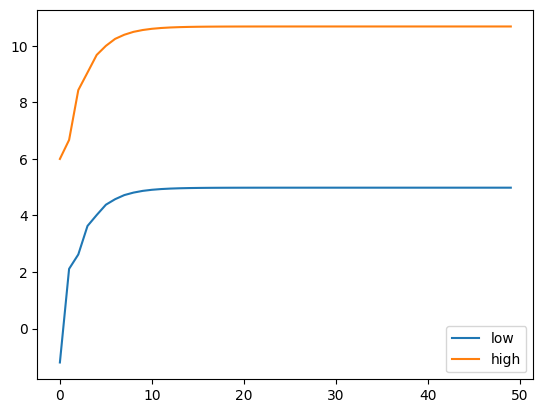

In [33]:
# reset V and Q to 0
V = np.zeros(nb_states)
Q = np.zeros((nb_states, nb_actions))
# gamma = 0.7

# track history of V_high and V_low
V_low_history = []
V_high_history = []

# Change the initial policy to the current result
# pi = np.array([a['search'], a['recharge']], dtype=int)

# Fill them with the prediction
for i in range(50):
  # 5 state actions
  Q[s['high'], a['search']] = alpha * (r_search + gamma * V[s['high']]) + (1 - alpha) * (r_search + gamma * V[s['low']])
  Q[s['low'], a['search']] = beta * (r_search + beta * V[s['low']]) + (1 - beta) * (-3 + gamma * V[s['high']])
  Q[s['high'], a['wait']] = r_wait + gamma * V[s['high']]
  Q[s['low'], a['wait']] = r_wait + gamma * V[s['low']]
  Q[s['low'], a['recharge']] = gamma * V[s['high']]

  # update the V-values
  V[s['high']] = Q[s['high'], pi[s['high']]]
  V[s['low']] = Q[s['low'], pi[s['low']]]

  V_low_history.append(V[s['low']])
  V_high_history.append(V[s['high']])

print(f"V[high]: {V[s['high']]}")
print(f"V[low]: {V[s['low']]}")

print(Q)

plt.plot(V_low_history, label='low')
plt.plot(V_high_history, label='high')
plt.legend()
plt.show()

**Q:** Do the V-values converge? How fast? What do the final values represent? Change the value of $\gamma$ and conclude on its importance (do not forget to reset the V and Q arrays to 0!).

**Q:** Print the Q-values at the end of the policy evaluation. What would the greedy policy with respect to these Q-values?

**Q:** Change the initial policy to this policy and evaluate it. What happens? Compare the final value of the states under both policies. Which one is the best?

### Policy iteration

Improving the policy is now straightforward. We just to look at the Q-values in each state, and change the policy so that it takes the action with the maximal Q-value. If this does not change the policy (we still take the same actions), we have found the optimal policy, we can stop.

**Q:** Implement policy iteration.

Do not forget to reset the V and Q arrays at the beginning of the cell, as well as the original policy.

Use an infinite loop that you will quit when the policy has not changed between two iterations. Something like:

```python
while True:
    # 1 - Policy evaluation
    for k in range(50):
        # Update the values
    
    # 2 - Policy improvement
    
    if pi != pi_old:
        break
```

**Beware:** if you simply assign the policy to another array and modify the policy:

```python
pi_old = pi
pi[s['high']] = a['search']
```

`pi_old` will also change! You need to `.copy()` the policy.

In [52]:
# reset V and Q to 0
pi = np.array([a['search'], a['search']], dtype=int)
V = np.zeros(nb_states)
Q = np.zeros((nb_states, nb_actions))

while True:
    # 1 - Policy evaluation
    for k in range(50):
        # Update the values
          # 5 state actions
          Q[s['high'], a['search']] = alpha * (r_search + gamma * V[s['high']]) + (1 - alpha) * (r_search + gamma * V[s['low']])
          Q[s['low'], a['search']] = beta * (r_search + beta * V[s['low']]) + (1 - beta) * (-3 + gamma * V[s['high']])
          Q[s['high'], a['wait']] = r_wait + gamma * V[s['high']]
          Q[s['low'], a['wait']] = r_wait + gamma * V[s['low']]
          Q[s['low'], a['recharge']] = gamma * V[s['high']]

          # update the V-values
          V[s['high']] = Q[s['high'], pi[s['high']]]
          V[s['low']] = Q[s['low'], pi[s['low']]]

    # 2 - Policy improvement
    pi_old = pi.copy()
    pi[s['high']] = np.argmax(Q[s['high']])
    pi[s['low']] = np.argmax(Q[s['low']])

    if pi[s['high']] == pi_old[s['high']] and pi[s['low']] == pi_old[s['low']]:
        break

print(Q)

[[13.42281873 11.39597309  0.        ]
 [ 6.6926174   8.57718115  9.39597309]]


## Value iteration

In value iteration, we merge the policy evaluation and improvement in a single update rule:

$$
    V (s) \leftarrow \max_{a \in \mathcal{A}(s)} \sum_{s' \in \mathcal{S}} p(s' | s, a) \, [ r(s, a, s') + \gamma \, V (s') ]
$$

The value of state takes the value of its greedy action. The policy is therefore implicitly greedy w.r.t the Q-values.

The algorithm becomes:

* while not converged:

    * for all states $s$:
    
        * Update the value estimates with:
        
        $$
            V (s)  \leftarrow \max_{a \in \mathcal{A}(s)} \sum_{s' \in \mathcal{S}} p(s' | s, a) \, [ r(s, a, s') + \gamma \, V (s') ]
        $$
        
**Q:** Modify your previous code to implement value iteration. Use a fixed number of iterations (e.g. 50) as in policy evaluation. Visualize the evolution of the V-values and print the greedy policy after each iteration. Conclude.

**Q:**  Change the value of the discount factor $\gamma =0.3$ so that the agent becomes short-sighted: it only takes into account the immediate rewards, but forgets about the long-term. Does it change the strategy? Explain why.

**Q:** Change $\gamma$ to 0.99 (far-sighted agent). What does it change and why?  

**Q:**  Change the parameters to:

$$\alpha = 0.01 \quad \beta = 0.2 \quad \gamma = 0.7 \quad \mathcal{R}^{\text{search}} = 6 \quad  \mathcal{R}^{\text{wait}} = 5$$

Find the optimal policy. What is the optimal action to be taken in the state *high*, although the probability to stay in this state is very small? Why?

**Q:** Find a set of parameters where it would be optimal to search while in the *low* state.